# Objective

The primary objective of this project is to develop a predictive model to determine the survival of passengers on the Titanic, utilizing the dataset provided by Kaggle. This task is a classic binary classification problem, where the model will predict a discrete outcome: 1 for survived or 0 for not survived. The methodology will encompass a comprehensive data science workflow, including data cleaning, thorough exploratory data analysis (EDA), strategic feature engineering, the selection of an optimal machine learning model, and subsequent hyperparameter tuning to maximize predictive accuracy.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Initial Exploration

I started by loading the training and testing datasets. Then, I performed initial checks to examine their structure, inspect data types, and identify any missing values. This initial exploration helped me plan the necessary preprocessing steps for the analysis.


In [ ]:
# Load the training and testing datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# Display the first 5 rows of the training data
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Display information about the training data, including data types and non-null counts
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Check for missing values in the training data
print(train_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# Calculate and print the skewness of the 'Age' column
print("Skewness of 'Age' column in train_df:", train_df['Age'].skew())

Skewness of 'Age' column in train_df: 0.38910778230082704


In [ ]:
# Calculate mean of Age, mode of Embarked, and median of Fare for imputation
age_mean_train = train_df['Age'].mean()
embarked_mode_train = train_df['Embarked'].mode()[0]
fare_median_train = train_df['Fare'].median()

## 2. Data Preprocessing and Feature Engineering

I focused on cleaning the data and creating new, more informative features. I imputed missing values in `Age`, `Fare`, and `Embarked` using statistical measures like the mean, median, and mode. I also engineered new features such as `FamilySize` (combining `SibSp` and `Parch`) and extracted titles from passenger names to create a `Title` feature. Finally, I converted categorical variables into numerical format using one-hot encoding and scaled numerical features to ensure the model performed effectively.


In [ ]:
# Impute missing values in 'Age' with the mean
train_df['Age'].fillna(age_mean_train, inplace=True)
test_df['Age'].fillna(age_mean_train, inplace=True)

# Impute missing values in 'Embarked' with the mode
train_df['Embarked'].fillna(embarked_mode_train, inplace=True)

# Impute missing values in 'Fare' with the median
test_df['Fare'].fillna(fare_median_train, inplace=True)

In [ ]:
# Create 'FamilySize' and 'IsAlone' features
for df in [train_df, test_df]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [ ]:
# Extract titles from the 'Name' column
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
# Clean and group less frequent titles
for df in [train_df, test_df]:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Print value counts for the cleaned 'Title' column
print("Cleaned Title Counts in Training Data:")
print(train_df['Title'].value_counts())

Cleaned Title Counts in Training Data:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


In [ ]:
# Drop irrelevant columns
train_df = train_df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch'], axis=1)

In [ ]:
# Perform one-hot encoding on categorical features
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

In [ ]:
# Separate target variable and store indices
train_labels = train_df['Survived']
train_ids = train_df.index
test_ids = test_df.index

In [ ]:
# Drop the 'Survived' column from the training data
train_df = train_df.drop(columns=['Survived'])

# Align columns of training and testing dataframes
train_df, test_df = train_df.align(test_df, join='inner', axis=1)

# Add the 'Survived' column back to the training data
train_df['Survived'] = train_labels

In [ ]:
# Separate features and target variable for training and testing
y_train = train_df['Survived']
X_train = train_df.drop('Survived', axis=1)
X_test = test_df

# Define numerical columns for scaling
numerical_cols = ['Pclass', 'Age', 'Fare', 'FamilySize']

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
# Display the head of the processed training data
print("--- Processed Training Data ---")
display(X_train.head())

--- Processed Training Data ---


,Pclass,Age,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0.827377,-0.592481,-0.502445,0.059160,0,True,False,True,False,True,False,False
1,-1.566107,0.638789,0.786845,0.059160,0,False,False,False,False,False,True,False
2,0.827377,-0.284663,-0.488854,-0.560975,1,False,False,True,True,False,False,False
3,-1.566107,0.407926,0.420730,0.059160,0,False,False,True,False,False,True,False
4,0.827377,0.407926,-0.486337,-0.560975,1,True,False,True,False,True,False,False


In [ ]:
# Display the head of the processed testing data
print("--- Processed Training Data ---")
display(X_test.head())

--- Processed Training Data ---


,Pclass,Age,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0.827377,0.369449,-0.490783,-0.560975,1,True,True,False,False,True,False,False
1,0.827377,1.331378,-0.507479,0.059160,0,False,False,True,False,False,True,False
2,-0.369365,2.485693,-0.453367,-0.560975,1,True,True,False,False,True,False,False
3,0.827377,-0.207709,-0.474005,-0.560975,1,True,False,True,False,True,False,False
4,0.827377,-0.592481,-0.401017,0.679295,0,False,False,True,False,False,True,False


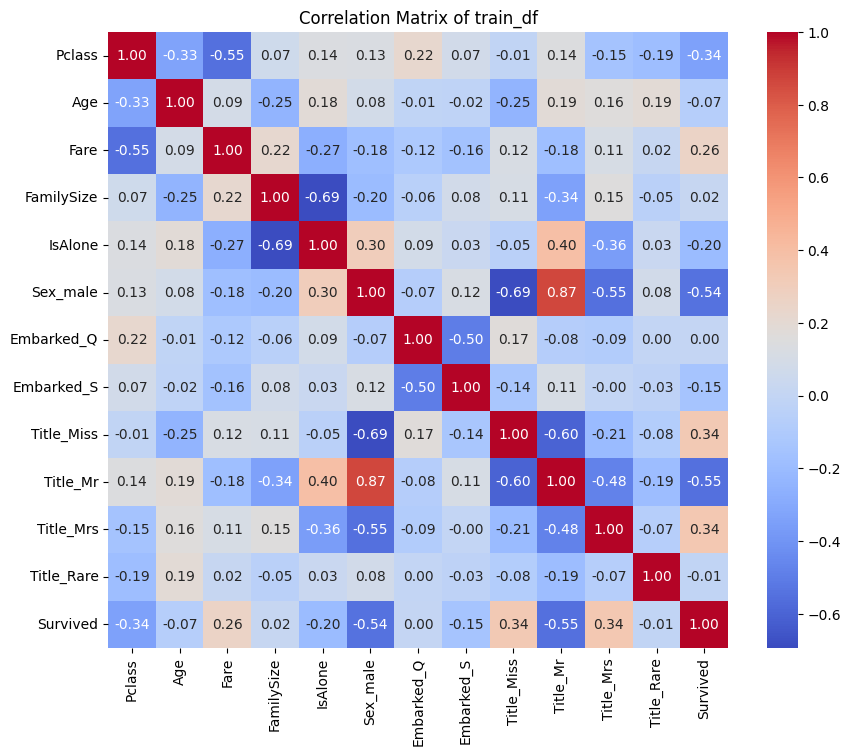

In [ ]:
# Plot the correlation matrix of the training data
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of train_df')
plt.show()

# 3. Exploratory Data Analysis (EDA)

After cleaning the dataset, I performed exploratory analysis to uncover patterns. I used a correlation matrix and various visualizations to examine relationships between different features and the survival outcome. This analysis highlighted key factors influencing survival, such as passenger class, sex, and age, providing insights to guide the modeling process.


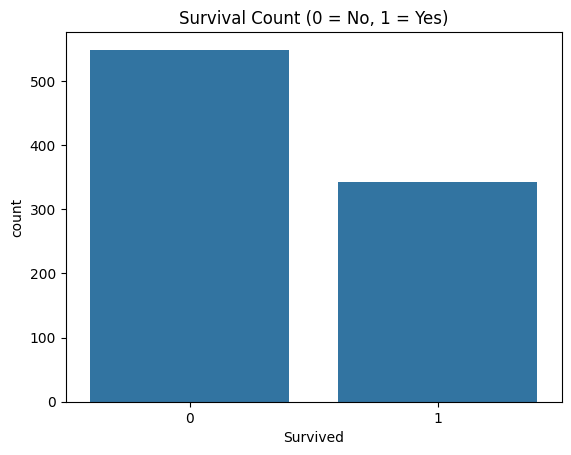

Survived
0    549
1    342
Name: count, dtype: int64


In [ ]:
# Plot the count of survivors and non-survivors
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Count (0 = No, 1 = Yes)')
plt.show()

# Print the value counts of the 'Survived' column
print(train_df['Survived'].value_counts())

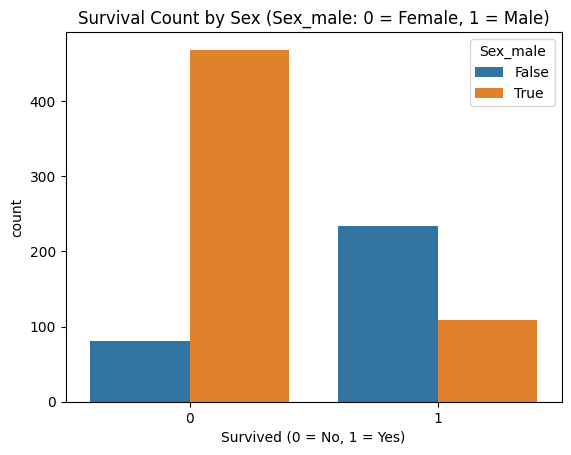

In [ ]:
# Plot survival count by sex
sns.countplot(x='Survived', hue='Sex_male', data=train_df)
plt.title('Survival Count by Sex (Sex_male: 0 = Female, 1 = Male)')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.show()

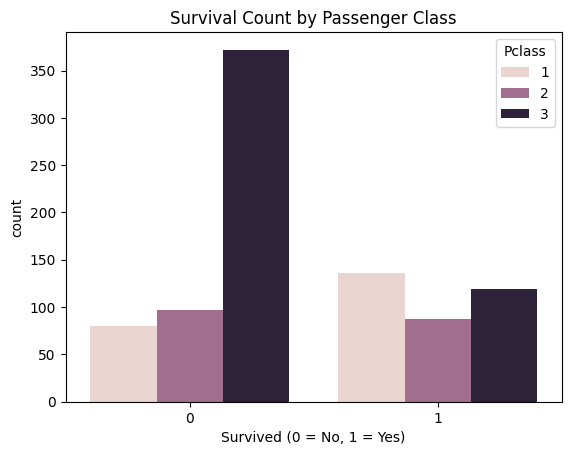

In [ ]:
# Plot survival count by passenger class
sns.countplot(x='Survived', hue='Pclass', data=train_df)
plt.title('Survival Count by Passenger Class')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.show()

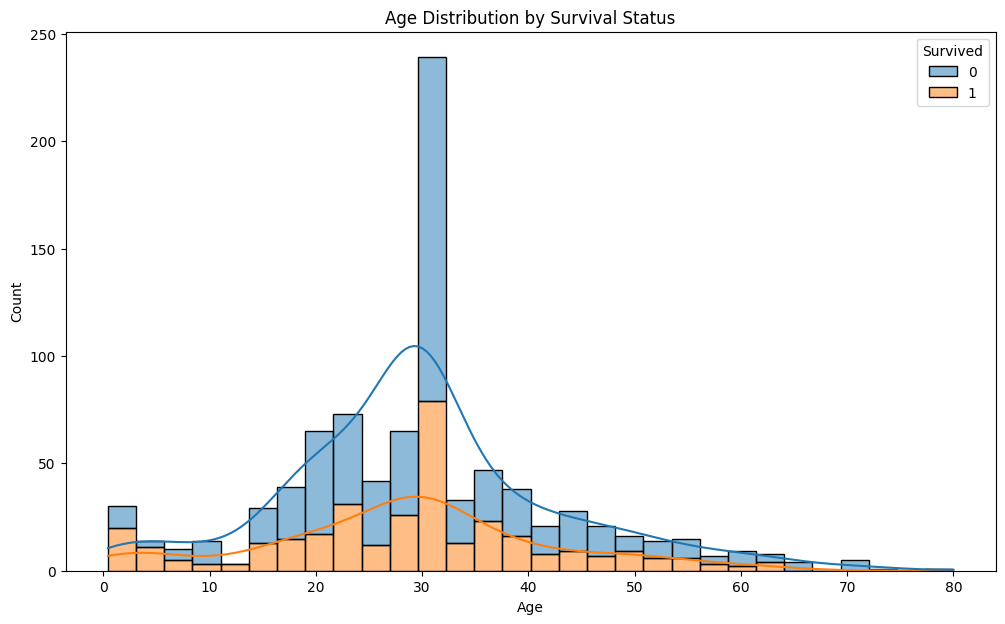

In [ ]:
# Plot age distribution by survival status
plt.figure(figsize=(12, 7))
sns.histplot(data=train_df, x='Age', hue='Survived', multiple="stack", bins=30, kde=True)
plt.title('Age Distribution by Survival Status')
plt.show()

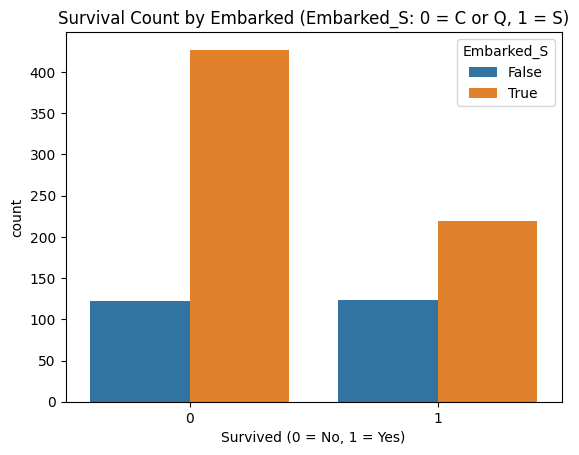

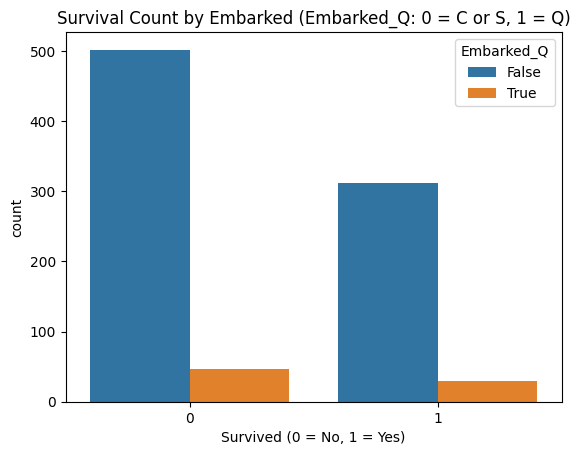

In [ ]:
# Plot survival count by embarkation point
sns.countplot(x='Survived', hue='Embarked_S', data=train_df)
plt.title('Survival Count by Embarked (Embarked_S: 0 = C or Q, 1 = S)')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.show()

sns.countplot(x='Survived', hue='Embarked_Q', data=train_df)
plt.title('Survival Count by Embarked (Embarked_Q: 0 = C or S, 1 = Q)')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.show()

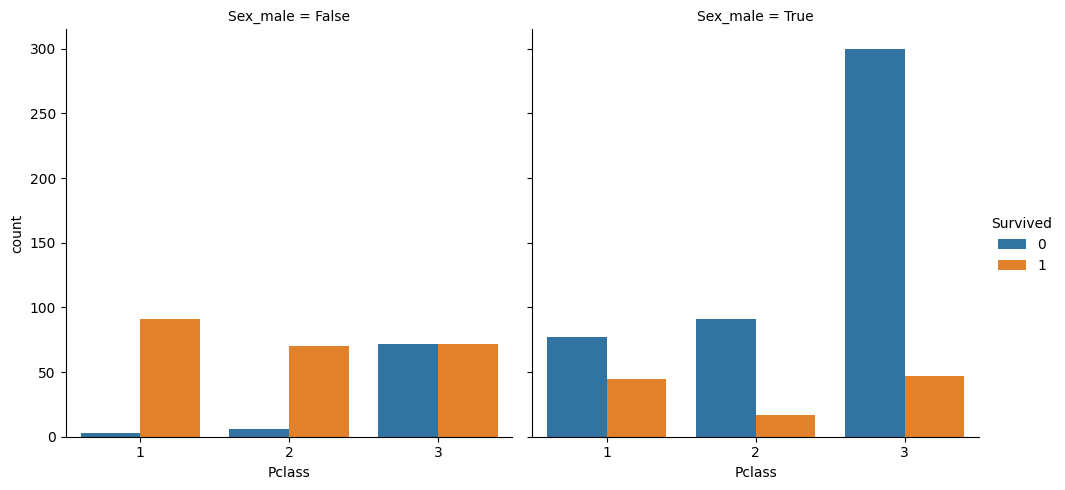

In [ ]:
# Plot survival count by passenger class and sex
sns.catplot(x='Pclass', hue='Survived', col='Sex_male', data=train_df, kind='count')
plt.show()

## 4. Model Building and Evaluation

I built and trained several classification models on the preprocessed data, including Logistic Regression, Decision Trees, Random Forests, and Gradient Boosting. I rigorously evaluated each model's performance using metrics such as accuracy and cross-validation scores to identify the most effective algorithm for predicting passenger survival.


In [ ]:
# Initialize and train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predict on training data and calculate accuracy
y_pred_train = model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training data: {accuracy:.4f}")

Accuracy on training data: 0.8316


In [ ]:
# Calculate F2 score on training data
f2_score_train = fbeta_score(y_train, y_pred_train, beta=2)
print(f"\nF2 Score on training data: {f2_score_train:.4f}")


F2 Score on training data: 0.7604


In [ ]:
# Calculate precision and recall on training data
precision = precision_score(y_train, y_pred_train)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_train, y_pred_train)
print(f"Recall: {recall:.4f}")

Precision: 0.7981
Recall: 0.7515


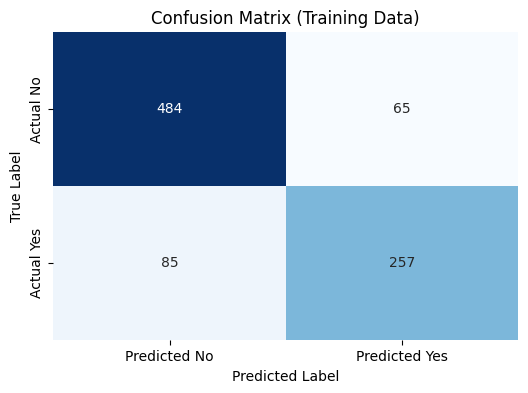

In [ ]:
# Plot the confusion matrix for the Logistic Regression model on training data
conf_matrix = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Training Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Perform cross-validation for Logistic Regression
cv_scores_lr = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation accuracy scores (Logistic Regression): {cv_scores_lr}")
print(f"Mean cross-validation accuracy (Logistic Regression): {cv_scores_lr.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy (Logistic Regression): {cv_scores_lr.std():.4f}")

Cross-validation accuracy scores (Logistic Regression): [0.81564246 0.82022472 0.80337079 0.80898876 0.84831461]
Mean cross-validation accuracy (Logistic Regression): 0.8193
Standard deviation of cross-validation accuracy (Logistic Regression): 0.0156


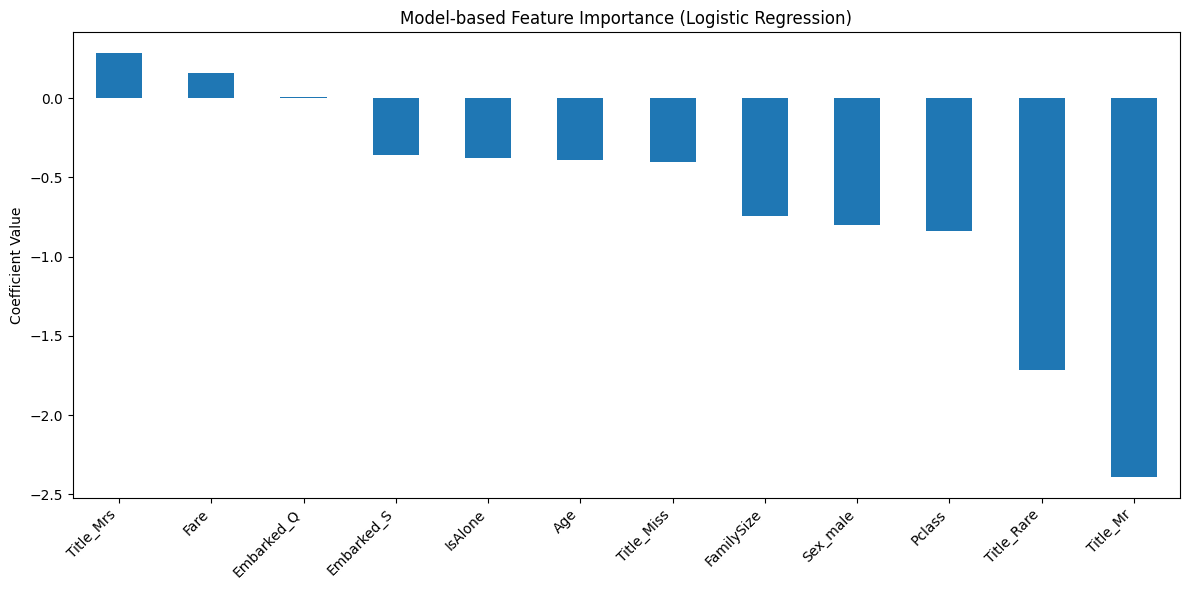

In [ ]:
# Plot feature importance for Logistic Regression
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance = pd.Series(coefficients, index=feature_names)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title('Model-based Feature Importance (Logistic Regression)')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Define parameter grid for Decision Tree GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# Initialize and perform GridSearchCV for Decision Tree
dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
# Evaluate the best Decision Tree model on training data
best_dt_model = grid_search.best_estimator_

y_pred_train_dt = best_dt_model.predict(X_train)

accuracy_dt = accuracy_score(y_train, y_pred_train_dt)
f2_score_train_dt = fbeta_score(y_train, y_pred_train_dt, beta=2)
precision_dt = precision_score(y_train, y_pred_train_dt)
recall_dt = recall_score(y_train, y_pred_train_dt)

print(f"Accuracy on training data (tuned Decision Tree): {accuracy_dt:.4f}")
print(f"F2 Score on training data (tuned Decision Tree): {f2_score_train_dt:.4f}")
print(f"Precision on training data (tuned Decision Tree): {precision_dt:.4f}")
print(f"Recall on training data (tuned Decision Tree): {recall_dt:.4f}")

Accuracy on training data (tuned Decision Tree): 0.8384
F2 Score on training data (tuned Decision Tree): 0.7692
Precision on training data (tuned Decision Tree): 0.8075
Recall on training data (tuned Decision Tree): 0.7602


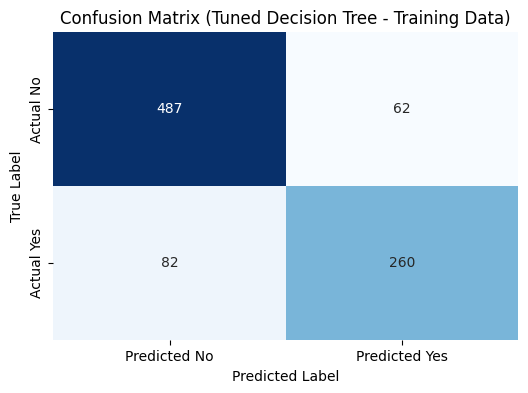

In [ ]:
# Plot confusion matrix for tuned Decision Tree on training data
y_pred_train_dt = best_dt_model.predict(X_train)
conf_matrix_dt = confusion_matrix(y_train, y_pred_train_dt)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Tuned Decision Tree - Training Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Perform cross-validation for the best Decision Tree model
cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy: {cv_scores.std():.4f}")

Cross-validation accuracy scores: [0.84357542 0.81460674 0.82022472 0.79775281 0.86516854]
Mean cross-validation accuracy: 0.8283
Standard deviation of cross-validation accuracy: 0.0236


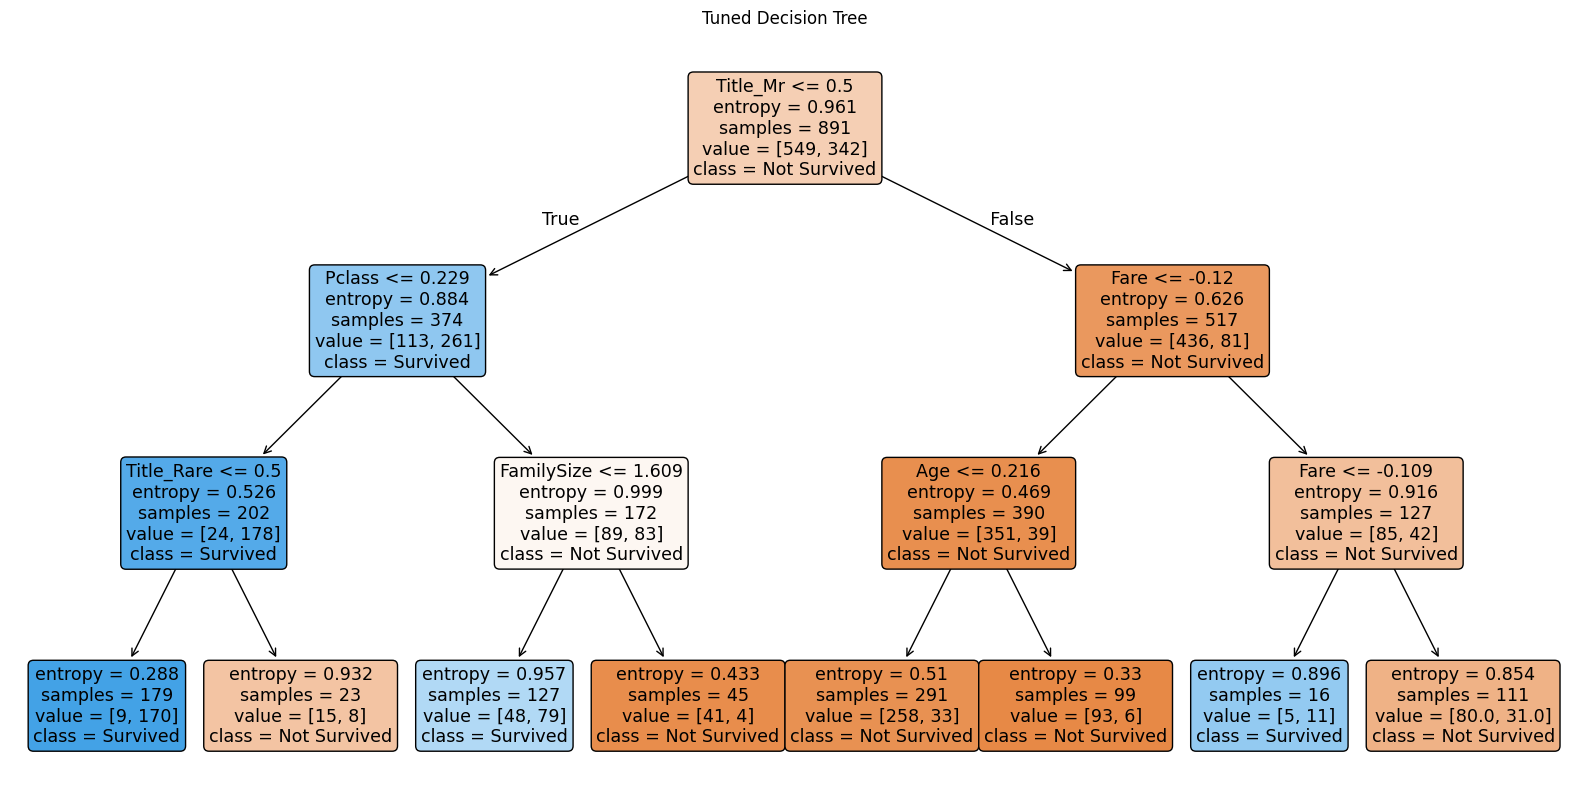

In [ ]:
# Plot the tuned Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title('Tuned Decision Tree')
plt.show()

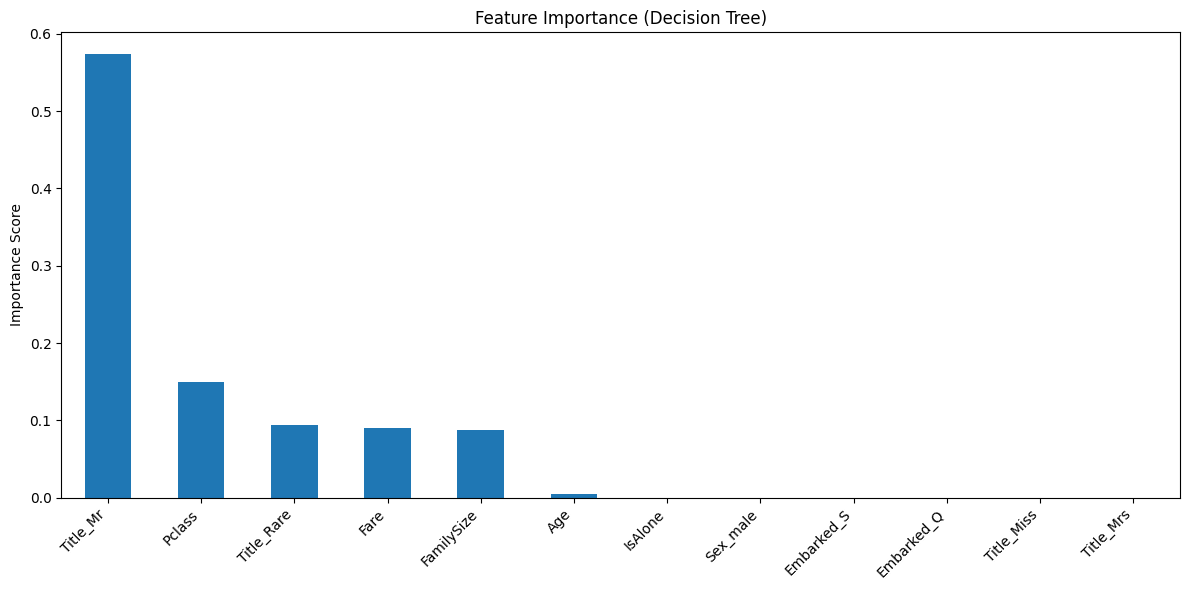

In [ ]:
# Plot feature importance for the Decision Tree
importances_dt = best_dt_model.feature_importances_
feature_importances_dt = pd.Series(importances_dt, index=X_train.columns)
feature_importances_dt = feature_importances_dt.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importances_dt.plot(kind='bar')
plt.title('Feature Importance (Decision Tree)')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning and Prediction

I optimized the performance of the best-performing model by performing hyperparameter tuning using techniques such as GridSearchCV and RandomizedSearchCV. Once fine-tuned, I used the model to make survival predictions on the unseen test dataset. The final output is a submission file containing `PassengerId` and the predicted survival status for each individual.


In [ ]:
# Define parameter grid for Random Forest GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# Initialize and perform GridSearchCV for Random Forest
rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [ ]:
# Evaluate the best Random Forest model on training data
best_rf_model = grid_search_rf.best_estimator_

y_pred_train_rf = best_rf_model.predict(X_train)

accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
f2_score_train_rf = fbeta_score(y_train, y_pred_train_rf, beta=2)
precision_rf = precision_score(y_train, y_pred_train_rf)
recall_rf = recall_score(y_train, y_pred_train_rf)

print(f"Accuracy on training data (tuned Random Forest): {accuracy_rf:.4f}")
print(f"F2 Score on training data (tuned Random Forest): {f2_score_train_rf:.4f}")
print(f"Precision on training data (tuned Random Forest): {precision_rf:.4f}")
print(f"Recall on training data (tuned Random Forest): {recall_rf:.4f}")

Accuracy on training data (tuned Random Forest): 0.9057
F2 Score on training data (tuned Random Forest): 0.8423
Precision on training data (tuned Random Forest): 0.9216
Recall on training data (tuned Random Forest): 0.8246


In [ ]:
# Perform cross-validation for the best Random Forest model
cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores (Random Forest): {cv_scores_rf}")
print(f"Mean cross-validation accuracy (Random Forest): {cv_scores_rf.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy (Random Forest): {cv_scores_rf.std():.4f}")

Cross-validation accuracy scores (Random Forest): [0.8547486  0.81460674 0.88764045 0.81460674 0.83707865]
Mean cross-validation accuracy (Random Forest): 0.8417
Standard deviation of cross-validation accuracy (Random Forest): 0.0275


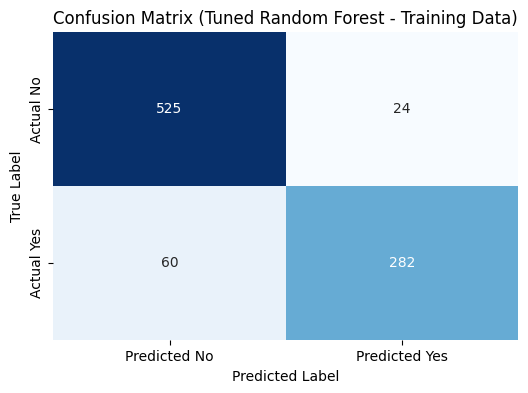

In [ ]:
# Plot confusion matrix for tuned Random Forest on training data
from sklearn.metrics import confusion_matrix
y_pred_train_rf = best_rf_model.predict(X_train)
conf_matrix_rf = confusion_matrix(y_train, y_pred_train_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Tuned Random Forest - Training Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

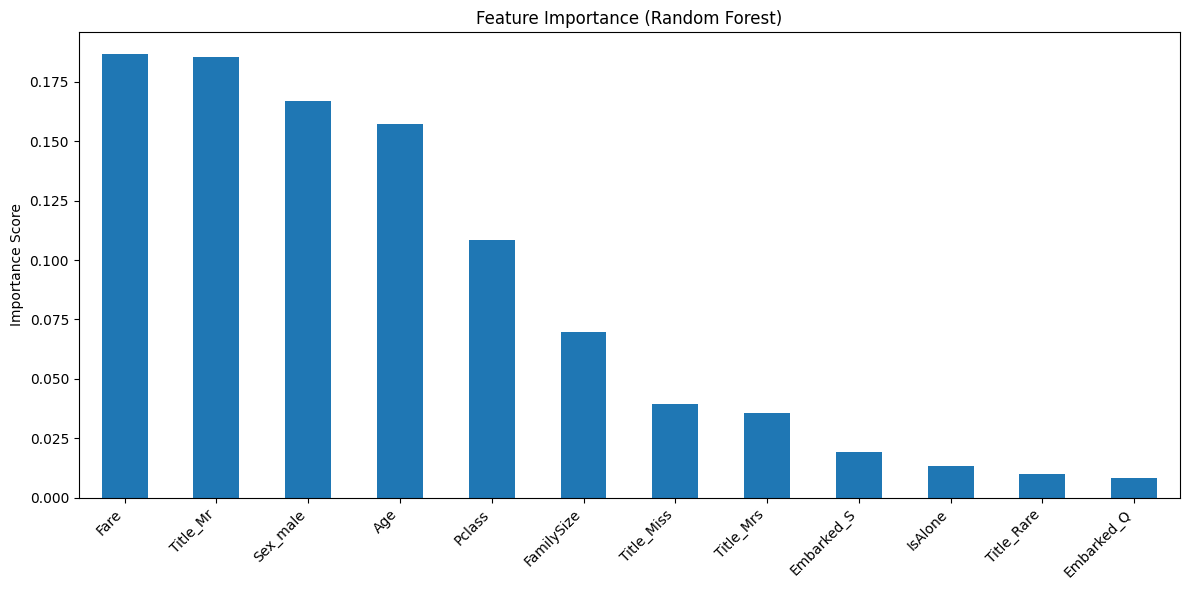

In [ ]:
# Plot feature importance for Random Forest
importances = best_rf_model.feature_importances_
feature_importances_rf = pd.Series(importances, index=X_train.columns)
feature_importances_rf = feature_importances_rf.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importances_rf.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Define parameter grid for KNN GridSearchCV
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [ ]:
# Initialize and perform GridSearchCV for KNN
knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
# Evaluate the best KNN model on training data
y_pred_train_knn = grid_search_knn.best_estimator_.predict(X_train)

accuracy_knn = accuracy_score(y_train, y_pred_train_knn)
print(f"Accuracy on training data (tuned KNN): {accuracy_knn:.4f}")

f2_score_train_knn = fbeta_score(y_train, y_pred_train_knn, beta=2)
print(f"F2 Score on training data (tuned KNN): {f2_score_train_knn:.4f}")

precision_knn = precision_score(y_train, y_pred_train_knn)
print(f"Precision on training data (tuned KNN): {precision_knn:.4f}")

recall_knn = recall_score(y_train, y_pred_train_knn)
print(f"Recall on training data (tuned KNN): {recall_knn:.4f}")

Accuracy on training data (tuned KNN): 0.8530
F2 Score on training data (tuned KNN): 0.7690
Precision on training data (tuned KNN): 0.8482
Recall on training data (tuned KNN): 0.7515


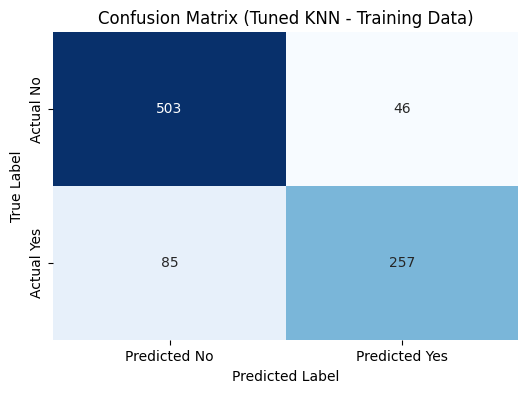

In [ ]:
# Plot confusion matrix for tuned KNN on training data
from sklearn.metrics import confusion_matrix
y_pred_train_knn = grid_search_knn.best_estimator_.predict(X_train)
conf_matrix_knn = confusion_matrix(y_train, y_pred_train_knn)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Tuned KNN - Training Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Initialize and perform GridSearchCV for KNN (duplicate)
knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train, y_train)

# Print best parameters and cross-validation score for KNN
print("Best parameters found: ", grid_search_knn.best_params_)
print("Best cross-validation accuracy: ", grid_search_knn.best_score_)

y_pred_train_knn = grid_search_knn.best_estimator_.predict(X_train)

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best cross-validation accuracy:  0.8249513527085556


In [ ]:
# Empty cell (no action)

In [ ]:
# Define parameter distribution for SVM RandomizedSearchCV
param_dist_svm = {
    'C': uniform(loc=0, scale=10),
    'gamma': uniform(loc=0, scale=1),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [ ]:
# Initialize and perform RandomizedSearchCV for SVM
svm = SVC(random_state=42)

random_search_svm = RandomizedSearchCV(svm, param_distributions=param_dist_svm, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

random_search_svm.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2fd4eb6b50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2fd4eb6610>,
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='accuracy')

In [ ]:
# Evaluate the best SVM model on training data
best_svm_model = random_search_svm.best_estimator_

y_pred_train_svm = best_svm_model.predict(X_train)

accuracy_svm = accuracy_score(y_train, y_pred_train_svm)
f2_score_train_svm = fbeta_score(y_train, y_pred_train_svm, beta=2)
precision_svm = precision_score(y_train, y_pred_train_svm)
recall_svm = recall_score(y_train, y_pred_train_svm)

print(f"Accuracy on training data (tuned SVM): {accuracy_svm:.4f}")
print(f"F2 Score on training data (tuned SVM): {f2_score_train_svm:.4f}")
print(f"Precision on training data (tuned SVM): {precision_svm:.4f}")
print(f"Recall on training data (tuned SVM): {recall_svm:.4f}")

Accuracy on training data (tuned SVM): 0.8552
F2 Score on training data (tuned SVM): 0.7468
Precision on training data (tuned SVM): 0.8817
Recall on training data (tuned SVM): 0.7193


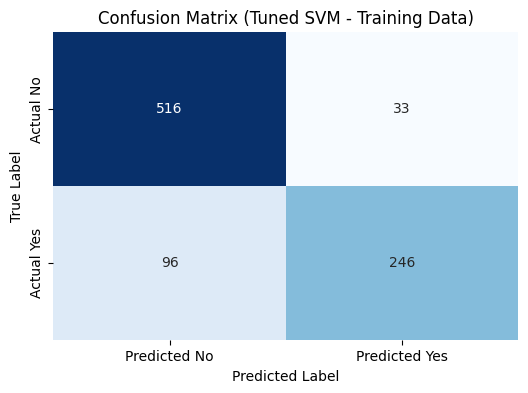

In [ ]:
# Plot confusion matrix for tuned SVM on training data
from sklearn.metrics import confusion_matrix
y_pred_train_svm = best_svm_model.predict(X_train)
conf_matrix_svm = confusion_matrix(y_train, y_pred_train_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Tuned SVM - Training Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Perform cross-validation for the best SVM model
cv_scores_svm = cross_val_score(best_svm_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores (SVM): {cv_scores_svm}")
print(f"Mean cross-validation accuracy (SVM): {cv_scores_svm.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy (SVM): {cv_scores_svm.std():.4f}")

Cross-validation accuracy scores (SVM): [0.82681564 0.83146067 0.83146067 0.79213483 0.89325843]
Mean cross-validation accuracy (SVM): 0.8350
Standard deviation of cross-validation accuracy (SVM): 0.0326


In [ ]:
# Define parameter distribution for Gradient Boosting RandomizedSearchCV
param_dist_gbm = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(loc=0.01, scale=0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(loc=0.5, scale=0.5)
}

In [ ]:
# Initialize and perform RandomizedSearchCV for Gradient Boosting
gbm = GradientBoostingClassifier(random_state=42)

random_search_gbm = RandomizedSearchCV(gbm, param_distributions=param_dist_gbm, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

random_search_gbm.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2fd4e697d0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2fd6c8f190>,
                                        'min_samples_leaf': <scipy.stats._distn_infrast...ete_frozen object at 0x7f2fd4e9b790>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2fd4e7de90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2fd6ae7b10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2fd6b0abd0>},
                   random_state=42, scoring='accuracy')

In [ ]:
# Evaluate the best Gradient Boosting model on training data
best_gbm_model = random_search_gbm.best_estimator_

y_pred_train_gbm = best_gbm_model.predict(X_train)

accuracy_gbm = accuracy_score(y_train, y_pred_train_gbm)
f2_score_train_gbm = fbeta_score(y_train, y_pred_train_gbm, beta=2)
precision_gbm = precision_score(y_train, y_pred_train_gbm)
recall_gbm = recall_score(y_train, y_pred_train_gbm)

print(f"Accuracy on training data (tuned Gradient Boosting): {accuracy_gbm:.4f}")
print(f"F2 Score on training data (tuned Gradient Boosting): {f2_score_train_gbm:.4f}")
print(f"Precision on training data (tuned Gradient Boosting): {precision_gbm:.4f}")
print(f"Recall on training data (tuned Gradient Boosting): {recall_gbm:.4f}")

Accuracy on training data (tuned Gradient Boosting): 0.8934
F2 Score on training data (tuned Gradient Boosting): 0.8289
Precision on training data (tuned Gradient Boosting): 0.8997
Recall on training data (tuned Gradient Boosting): 0.8129


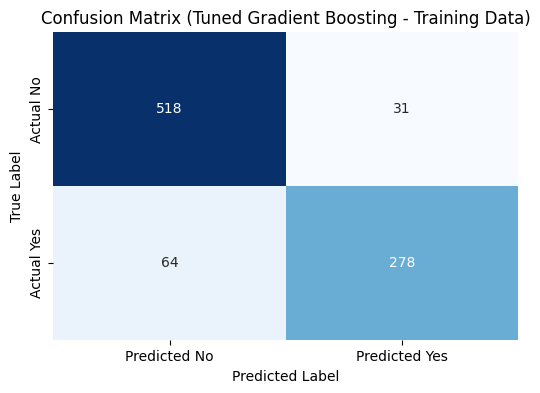

In [ ]:
# Plot confusion matrix for tuned Gradient Boosting on training data
best_gbm_model = random_search_gbm.best_estimator_
y_pred_train_gbm = best_gbm_model.predict(X_train)
conf_matrix_gbm = confusion_matrix(y_train, y_pred_train_gbm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Tuned Gradient Boosting - Training Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Perform cross-validation for the best Gradient Boosting model
cv_scores_gbm = cross_val_score(best_gbm_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation accuracy scores (Gradient Boosting): {cv_scores_gbm}")
print(f"Mean cross-validation accuracy (Gradient Boosting): {cv_scores_gbm.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy (Gradient Boosting): {cv_scores_gbm.std():.4f}")

Cross-validation accuracy scores (Gradient Boosting): [0.83798883 0.83707865 0.88764045 0.81460674 0.83146067]
Mean cross-validation accuracy (Gradient Boosting): 0.8418
Standard deviation of cross-validation accuracy (Gradient Boosting): 0.0244


In [ ]:
# Initialize and train a Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Evaluate the Naive Bayes model on training data
y_pred_train_gnb = gnb.predict(X_train)

accuracy_gnb = accuracy_score(y_train, y_pred_train_gnb)
f2_score_train_gnb = fbeta_score(y_train, y_pred_train_gnb, beta=2)
precision_gnb = precision_score(y_train, y_pred_train_gnb)
recall_gnb = recall_score(y_train, y_pred_train_gnb)

print(f"Accuracy on training data (Naive Bayes): {accuracy_gnb:.4f}")
print(f"F2 Score on training data (Naive Bayes): {f2_score_train_gnb:.4f}")
print(f"Precision on training data (Naive Bayes): {precision_gnb:.4f}")
print(f"Recall on training data (Naive Bayes): {recall_gnb:.4f}")

Accuracy on training data (Naive Bayes): 0.7845
F2 Score on training data (Naive Bayes): 0.7046
Precision on training data (Naive Bayes): 0.7287
Recall on training data (Naive Bayes): 0.6988


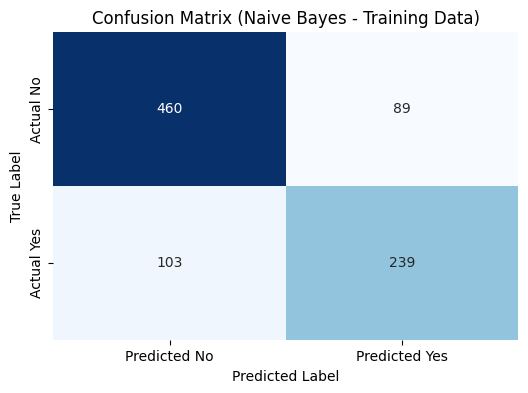

In [ ]:
# Plot confusion matrix for Naive Bayes on training data
conf_matrix_gnb = confusion_matrix(y_train, y_pred_train_gnb)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gnb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Naive Bayes - Training Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Perform cross-validation for the Naive Bayes model
cv_scores_gnb = cross_val_score(gnb, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy scores (Naive Bayes): {cv_scores_gnb}")
print(f"Mean cross-validation accuracy (Naive Bayes): {cv_scores_gnb.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy (Naive Bayes): {cv_scores_gnb.std():.4f}")


Cross-validation accuracy scores (Naive Bayes): [0.7877095  0.80337079 0.7752809  0.73595506 0.80898876]
Mean cross-validation accuracy (Naive Bayes): 0.7823
Standard deviation of cross-validation accuracy (Naive Bayes): 0.0260


## 6. Model Comparison and Selection

After training and evaluating multiple models, we compare their performance based on the calculated metrics. We focus on metrics relevant to the problem, such as the F2 score and cross-validation accuracy, to identify the best performing model for predicting passenger survival.

In [ ]:
# Create a DataFrame to compare model performance metrics
from sklearn.metrics import f1_score

metrics_data = {
    'Model': ['Logistic Regression', 'Decision Tree (Tuned)', 'Random Forest (Tuned)', 'KNN (Tuned)', 'SVM (Tuned)', 'Naive Bayes', 'Gradient Boosting (Tuned)'],
    'Accuracy (Train)': [accuracy, accuracy_dt, accuracy_rf, accuracy_knn, accuracy_svm, accuracy_gnb, accuracy_gbm],
    'Precision (Train)': [precision, precision_dt, precision_rf, precision_knn, precision_svm, precision_gnb, precision_gbm],
    'Recall (Train)': [recall, recall_dt, recall_rf, recall_knn, recall_svm, recall_gnb, recall_gbm],
    'F1 Score (Train)': [
        f1_score(y_train, model.predict(X_train)),
        f1_score(y_train, best_dt_model.predict(X_train)),
        f1_score(y_train, best_rf_model.predict(X_train)),
        f1_score(y_train, grid_search_knn.best_estimator_.predict(X_train)),
        f1_score(y_train, best_svm_model.predict(X_train)),
        f1_score(y_train, gnb.predict(X_train)),
        f1_score(y_train, best_gbm_model.predict(X_train))
    ],
     'F2 Score (Train)': [f2_score_train, f2_score_train_dt, f2_score_train_rf, f2_score_train_knn, f2_score_train_svm, f2_score_train_gnb, f2_score_train_gbm],
    'CV Accuracy (Mean)': [
        cv_scores_lr.mean() if 'cv_scores_lr' in locals() else None,
        cv_scores.mean() if 'cv_scores' in locals() else None,
        cv_scores_rf.mean() if 'cv_scores_rf' in locals() else None,
        grid_search_knn.best_score_ if 'grid_search_knn' in locals() else None,
        random_search_svm.best_score_ if 'random_search_svm' in locals() else None,
        cv_scores_gnb.mean() if 'cv_scores_gnb' in locals() else None,
        random_search_gbm.best_score_ if 'random_search_gbm' in locals() else None
    ]
}
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),F2 Score (Train),CV Accuracy (Mean)
0,Logistic Regression,0.831650,0.798137,0.751462,0.774096,0.760355,0.819308
1,Decision Tree (Tuned),0.838384,0.807453,0.760234,0.783133,0.769231,0.828266
2,Random Forest (Tuned),0.905724,0.921569,0.824561,0.870370,0.842294,0.841736
3,KNN (Tuned),0.852974,0.848185,0.751462,0.796899,0.769001,0.824951
4,SVM (Tuned),0.855219,0.881720,0.719298,0.792271,0.746812,0.835026
5,Naive Bayes,0.784512,0.728659,0.698830,0.713433,0.704599,0.782261
6,Gradient Boosting (Tuned),0.893378,0.899676,0.812865,0.854071,0.828861,0.841755


In [ ]:
# Identify and display the top 3 performing models
top_models = model_comparison.sort_values(by=['F2 Score (Train)', 'CV Accuracy (Mean)'], ascending=[False, False]).head(3)

print("\n--- Top 3 Performing Models (Sorted by F2 Score and Mean CV Accuracy) ---")
display(top_models)


--- Top 3 Performing Models (Sorted by F2 Score and Mean CV Accuracy) ---


,Accuracy (Train),F2 Score (Train),Precision (Train),Recall (Train),CV Accuracy (Mean),CV Accuracy (Std)
Random Forest,0.905724,0.842294,0.921569,0.824561,0.841736,0.027460
Gradient Boosting,0.893378,0.828861,0.899676,0.812865,0.841755,0.024432
Decision Tree,0.838384,0.769231,0.807453,0.760234,0.828266,0.023573


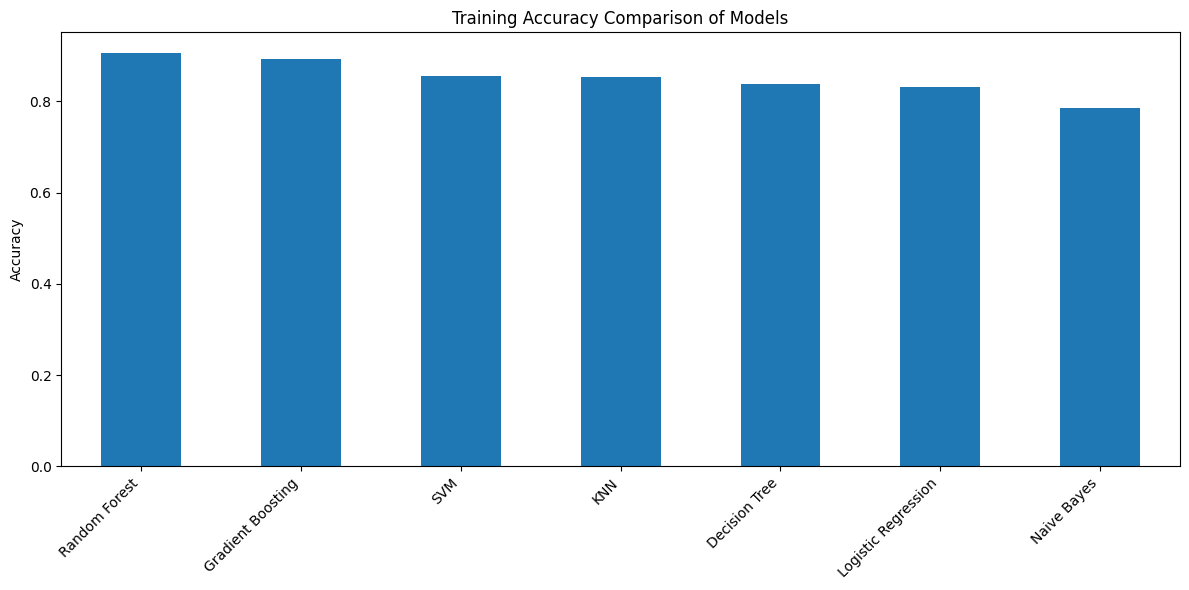

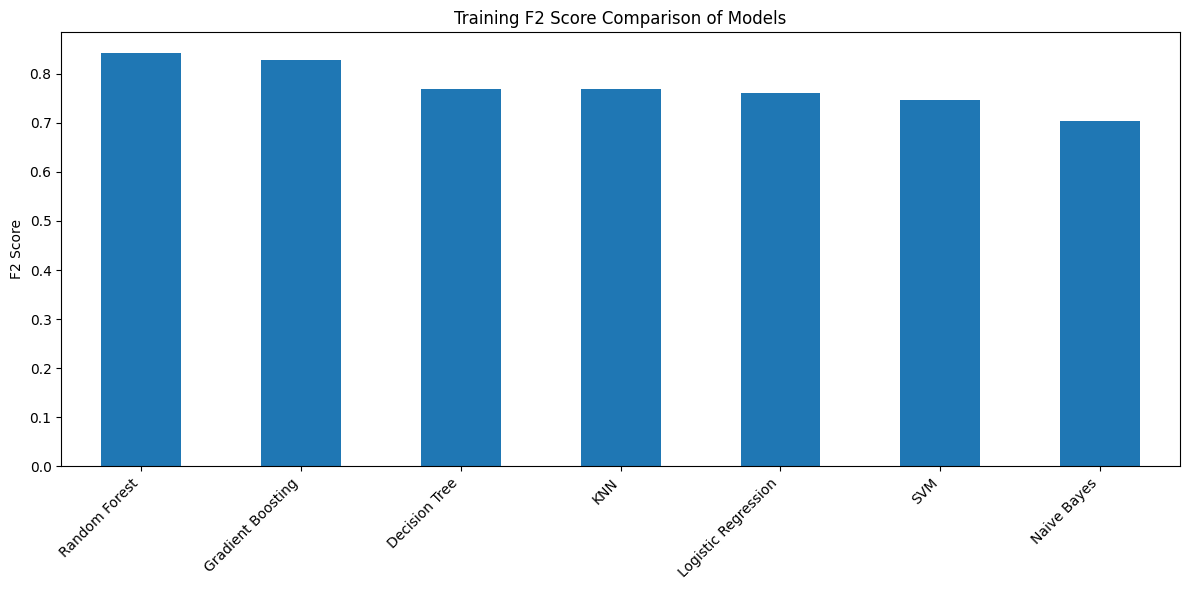

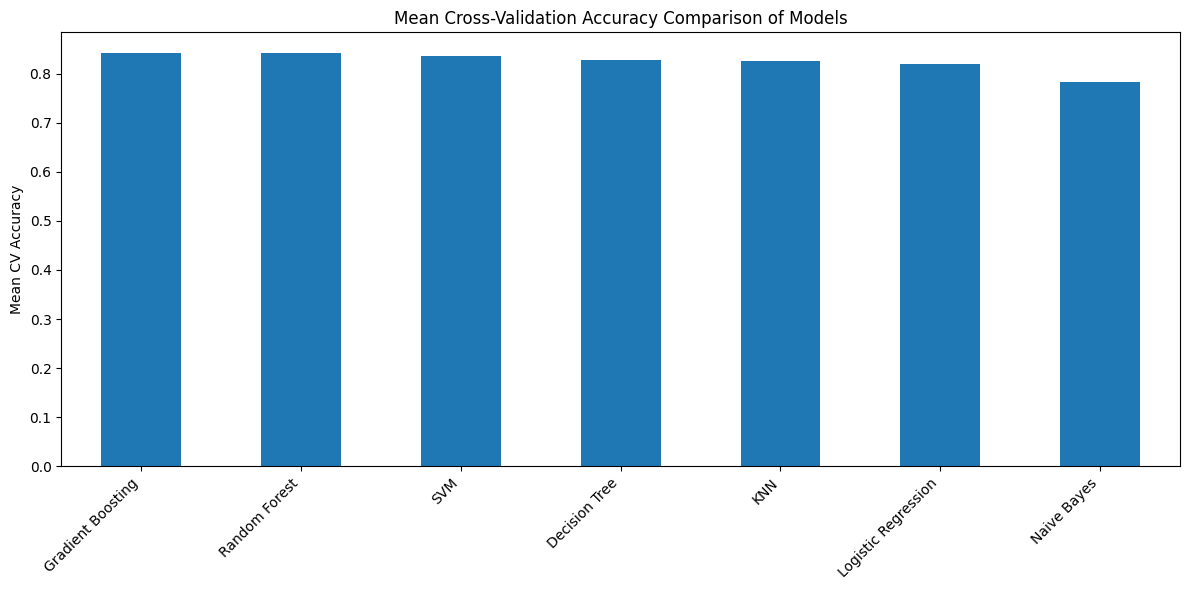

In [ ]:
# Plot comparison of model performance metrics
plt.figure(figsize=(12, 6))
model_comparison['Accuracy (Train)'].sort_values(ascending=False).plot(kind='bar')
plt.title('Training Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
model_comparison['F2 Score (Train)'].sort_values(ascending=False).plot(kind='bar')
plt.title('Training F2 Score Comparison of Models')
plt.ylabel('F2 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
model_comparison['CV Accuracy (Mean)'].sort_values(ascending=False).plot(kind='bar')
plt.title('Mean Cross-Validation Accuracy Comparison of Models')
plt.ylabel('Mean CV Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Final model comparison and selection of the best model
model_comparison = pd.DataFrame(metrics_data).set_index('Model')
model_comparison['CV Accuracy (Std)'] = [
    cv_scores_lr.std() if 'cv_scores_lr' in locals() else None,
    cv_scores.std() if 'cv_scores' in locals() else None,
    cv_scores_rf.std() if 'cv_scores_rf' in locals() else None,
    None, # KNN CV std was not explicitly calculated/stored in the original notebook
    cv_scores_svm.std() if 'cv_scores_svm' in locals() else None,
    cv_scores_gnb.std() if 'cv_scores_gnb' in locals() else None,
    cv_scores_gbm.std() if 'cv_scores_gbm' in locals() else None
]

print("--- Model Comparison ---")
display(model_comparison)

# Select the best performing model (Random Forest based on F2 and CV Accuracy)
best_model = best_rf_model

--- Model Comparison ---


,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),F2 Score (Train),CV Accuracy (Mean),CV Accuracy (Std)
Model,,,,,,,
Logistic Regression,0.831650,0.798137,0.751462,0.774096,0.760355,0.819308,0.015596
Decision Tree (Tuned),0.838384,0.807453,0.760234,0.783133,0.769231,0.828266,0.023573
Random Forest (Tuned),0.905724,0.921569,0.824561,0.870370,0.842294,0.841736,0.027460
KNN (Tuned),0.852974,0.848185,0.751462,0.796899,0.769001,0.824951,NaN
SVM (Tuned),0.855219,0.881720,0.719298,0.792271,0.746812,0.835026,0.032630
Naive Bayes,0.784512,0.728659,0.698830,0.713433,0.704599,0.782261,0.026010
Gradient Boosting (Tuned),0.893378,0.899676,0.812865,0.854071,0.828861,0.841755,0.024432


In [ ]:
# Generate predictions on the test data using the best model
test_predictions = best_model.predict(X_test)

In [ ]:
# Create the submission DataFrame
submission_df = pd.DataFrame({'PassengerId': test_ids, 'Survived': test_predictions})

In [ ]:
# Display the head of the submission DataFrame
display(submission_df.head())

,PassengerId,Survived
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [ ]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

## 6. Conclusion

For this Task I followed a comprehensive machine learning workflow to predict Titanic passenger survival. I performed data loading, preprocessing, feature engineering, and extensive exploratory data analysis to understand the dataset and identify potential predictors of survival.

I then trained and evaluated several classification models, including Logistic Regression, Decision Tree, Random Forest, KNN, SVM, Gradient Boosting, and Naive Bayes, using various metrics and cross-validation. Based on my analysis, particularly focusing on the F2 score and cross-validation accuracy, the **Random Forest model** emerged as the best performer for this task.

The feature importance analysis from the models highlighted that 'Fare', 'Title_Mr', 'Sex_male', 'Age', and 'Pclass' were among the most influential factors in predicting survival. Finally, I used the tuned Random Forest model to generate predictions on the unseen test data and created a submission file.

This project demonstrates my typical approach to a binary classification problem, from initial data exploration to model selection and prediction. The chosen Random Forest model provides a solid foundation for predicting survival on the Titanic dataset.